In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [2]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

In [3]:
gsp["datetime_gmt"].values[(gsp["datetime_gmt"] >= np.datetime64("2020-01-01")) & (gsp["datetime_gmt"] < np.datetime64("2022-01-01"))]

array(['2020-01-01T00:00:00.000000000', '2020-01-01T00:30:00.000000000',
       '2020-01-01T01:00:00.000000000', ...,
       '2021-12-31T22:30:00.000000000', '2021-12-31T23:00:00.000000000',
       '2021-12-31T23:30:00.000000000'], dtype='datetime64[ns]')

In [4]:
evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [79]:
# stolen from datapipes

from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )


def build_datasets_from_local(step: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(f"/home/tom/local_data/basic_processed_nwp_data_step_{step}.npy")
    X = pd.DataFrame(data=X.reshape(X.shape[1], X.shape[2]).T, columns=nwp.coords["variable"], index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    # add lagged values of GSP PV
    ar_1 = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    ar_day = y.shift(freq = - (shift + np.timedelta64(1, "D")))
    ar_1.columns = ["PV_LAG_1HR"]
    ar_day.columns = ["PV_LAG_DAY"]
    
    # estimate linear trend of the PV
    window_size = 10
    epsilon = 0.01
    y_covariates = y.shift(freq = -(shift + np.timedelta64(2, "h")))
    y_covariates.columns = ["x"]
    y_target = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    y_target.columns = ["y"]
    data = pd.concat([y_target, y_covariates], axis=1).dropna()
    _x = data["x"].values
    _y = data["y"].values
    _betas = np.nan * np.empty(len(data))
    
    for n in range(window_size, len(data)):
        __y = _y[(n-window_size): n]
        __x = _x[(n-window_size): n]
        __b = max(min((1 / ((__x.T @ __x) + epsilon))  * (__x.T @ __y), 10), -10)
        _betas[n] = __b
    
    betas = pd.DataFrame(data=_betas, columns=["AR_Beta"], index=data.index)
    
    X = pd.concat([X, ar_1, ar_day, betas], axis=1).dropna()
    y = y.loc[X.index]
    
    
    return X, y

In [200]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'n_estimators': 2500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [201]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16


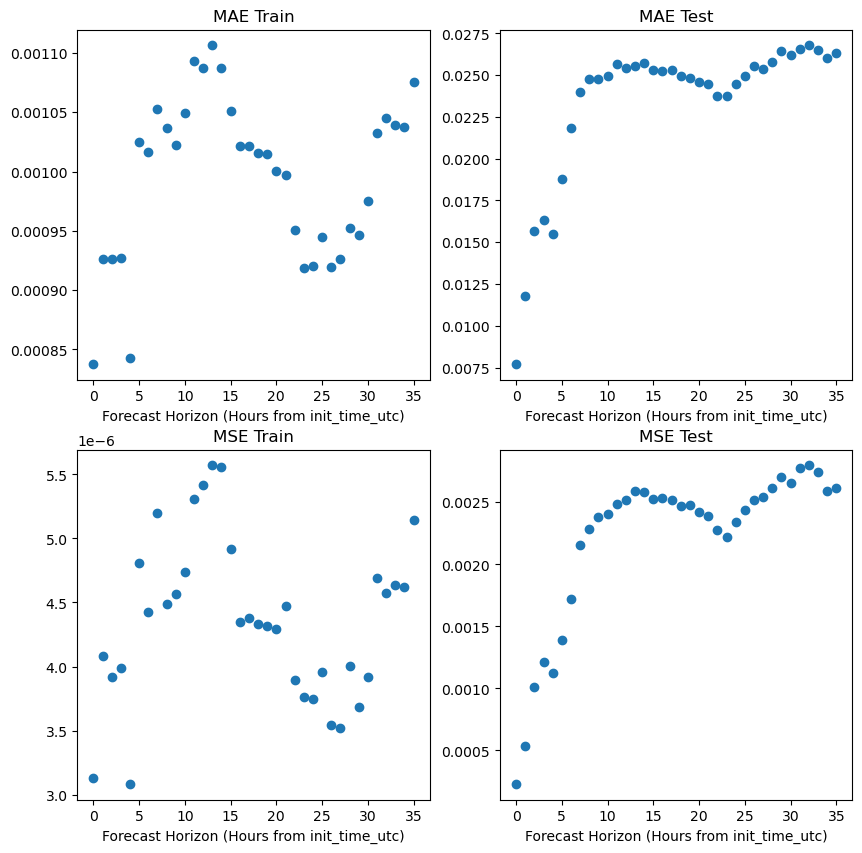

In [ ]:
# plot the MAE of the OOS for each model
from typing import Dict

def plot_loss_metrics(results_by_fh: Dict[int, ExperimentSummary]):
    title_mapping = {"MAE Train": lambda x: x.mae_train_loss,
                     "MAE Test": lambda x: x.mae_test_loss,
                     "MSE Train": lambda x: x.mse_train_loss,
                     "MSE Test": lambda x: x.mse_test_loss}
    
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    
    for idx, title in enumerate(title_mapping.keys()):
        row = int(idx > 1)
        col = idx % 2
        data = pd.Series({step: title_mapping[title](r) for step, r in results.items()})
        axes[row][col].scatter(data.index, data.values)
        axes[row][col].set_title(title)
        axes[row][col].set_xlabel("Forecast Horizon (Hours from init_time_utc)")

plot_loss_metrics(results)

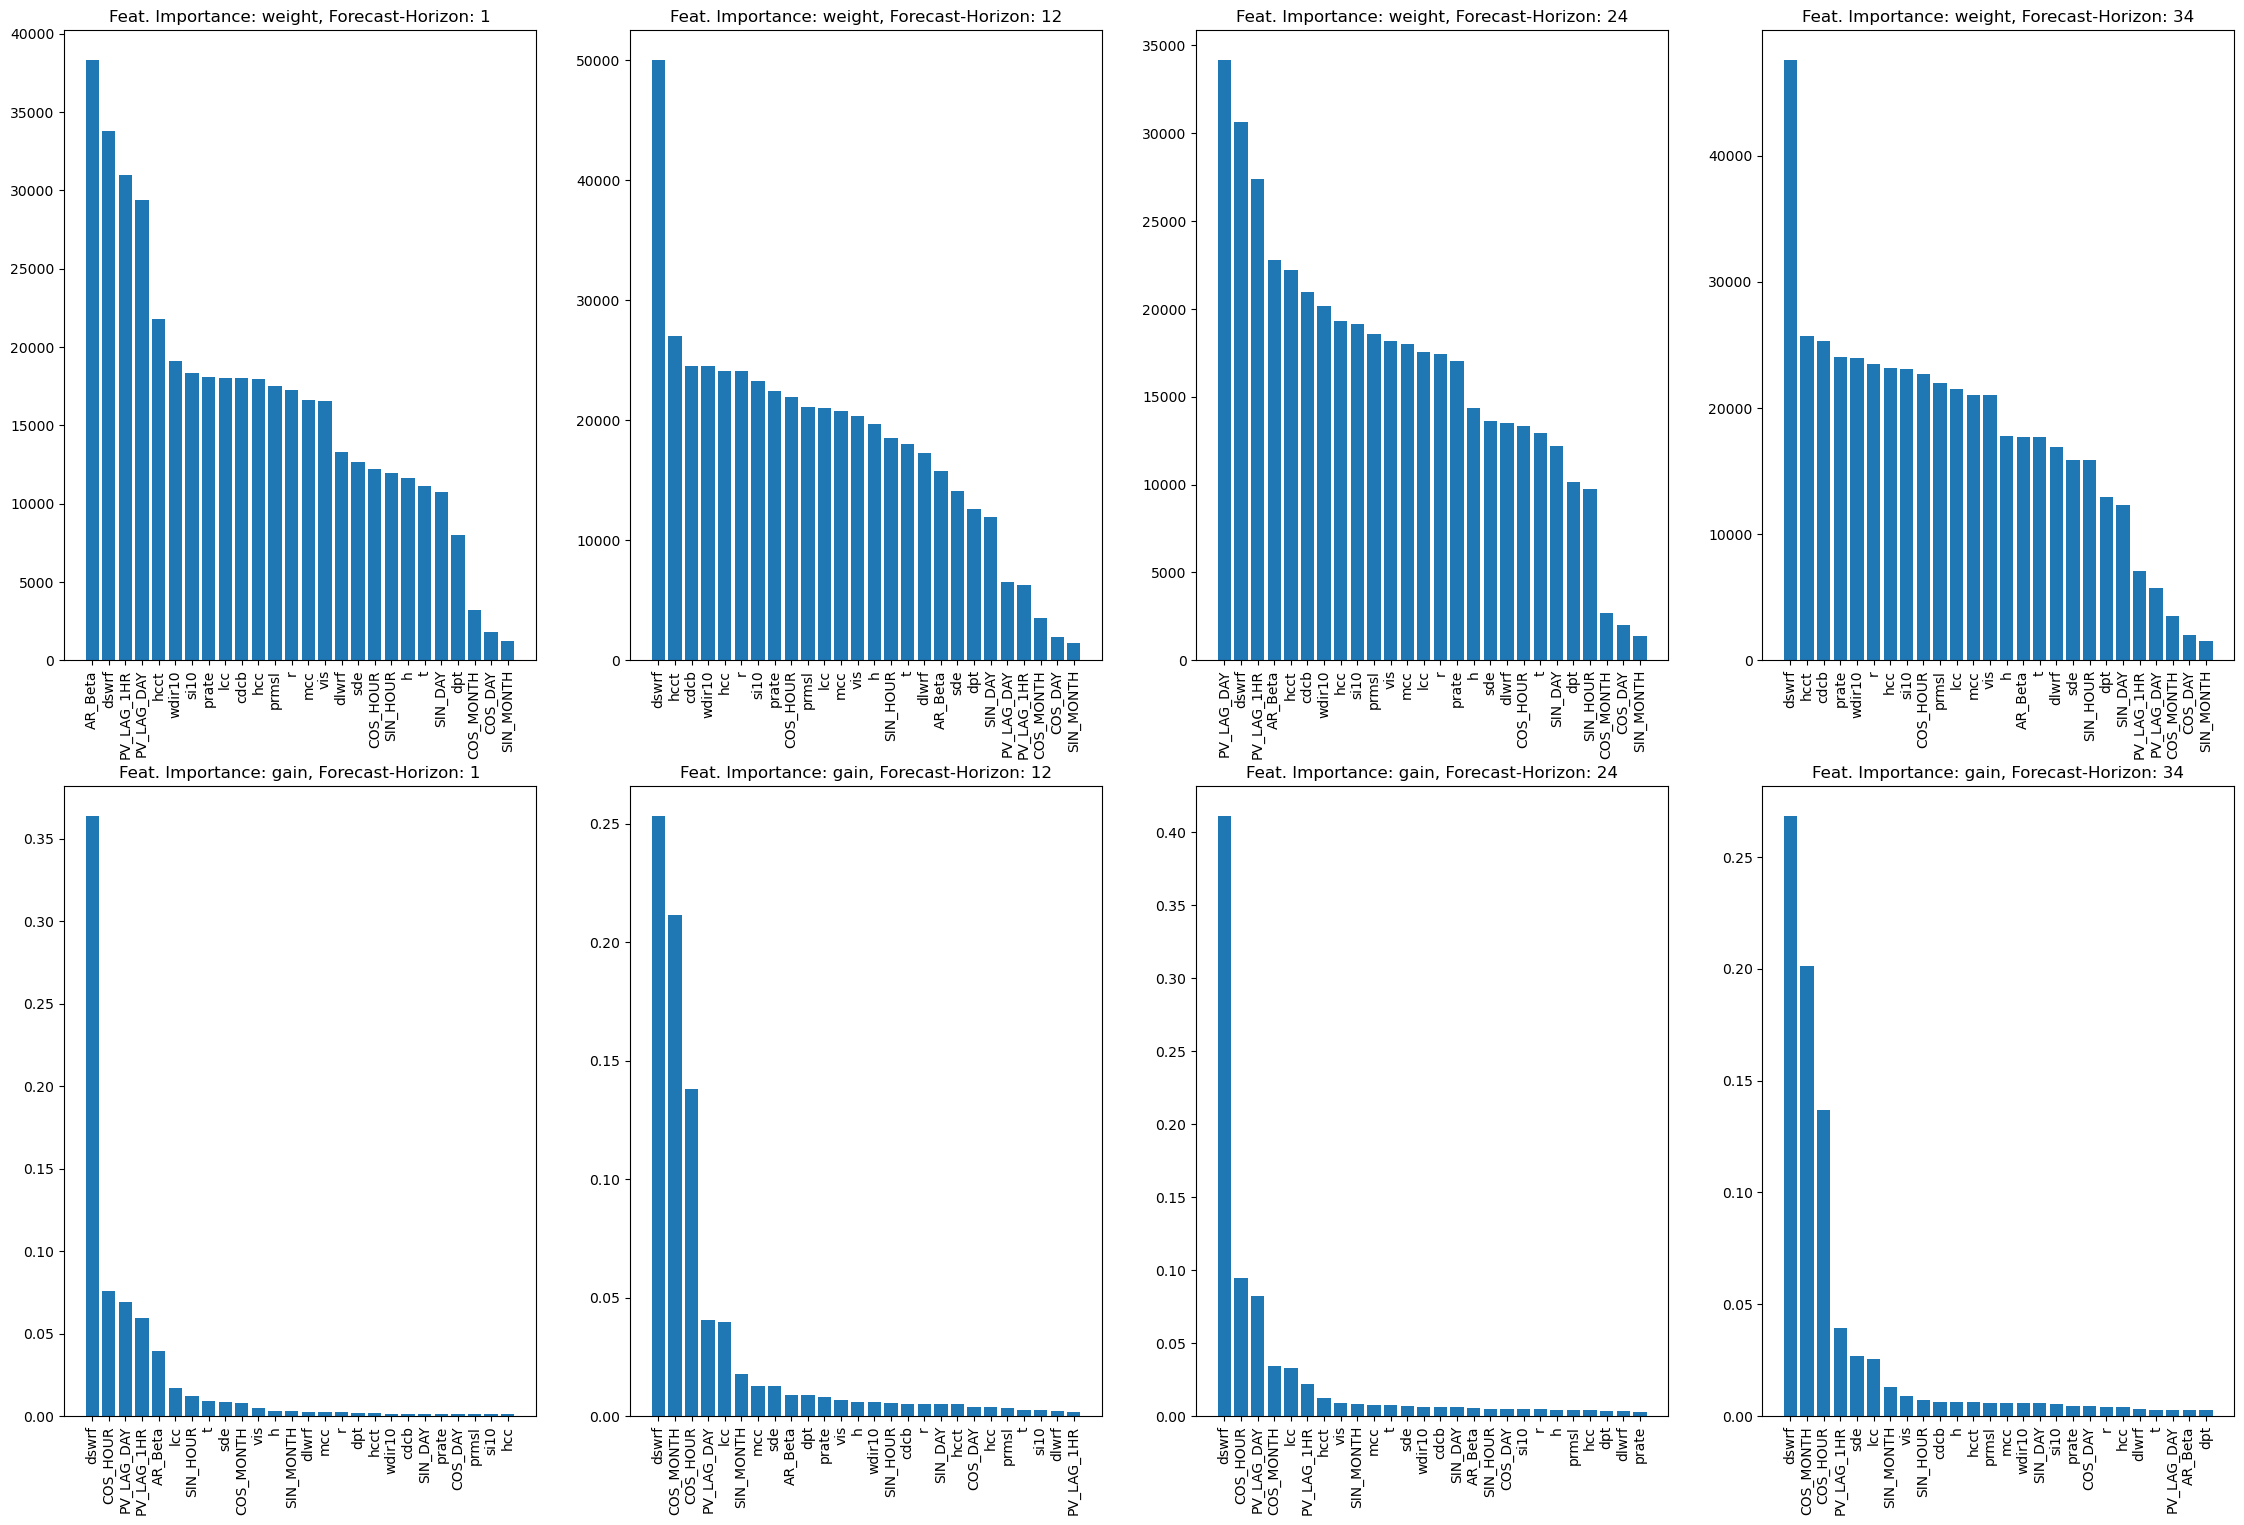

In [133]:
def plot_feature_importances(results_by_fh: Dict[int, ExperimentSummary], forecast_horizons = [1, 12, 24, 34]):
    assert len(forecast_horizons) == 4, "Plotting built for 4 forecast horizons!!"
    fig, axes = plt.subplots(2, 4, figsize=(28, 18))
    
    for param_idx, param in enumerate(["weight", "gain"]):
        for idx, fh in enumerate(forecast_horizons):
            data = pd.DataFrame.from_dict(results_by_fh[fh].model.get_booster().get_score(importance_type=param), orient="index").sort_values(by=0, ascending=False)
            axes[param_idx][idx].bar(range(len(data)), data.values.flatten())#, tick_label=data.index)
            axes[param_idx][idx].set_xticks(range(len(data)))
            axes[param_idx][idx].set_xticklabels(data.index, rotation=90)
            axes[param_idx][idx].set_title(f"Feat. Importance: {param}, Forecast-Horizon: {fh}")
            
        

test = plot_feature_importances(results)

# pd.DataFrame.from_dict(results[30].model.get_booster().get_score(importance_type='weight'), orient="index").sort_values(by=0, ascending=False).plot.bar()
# pd.DataFrame.from_dict(results[0].model.get_booster().get_score(importance_type='weight'), orient="index").sort_values(by=0, ascending=False).plot.bar()

In [158]:
# Trying to understand why 24hours performs better than ~18 hours.
# Initial intution is that the NWP forecast for +24 hours is more accurate
# than +18, despite being further away, and this is reflected in the model.

@dataclass
class ExperimentSummaryGroupInitTime:
    mse_train_loss: pd.Series
    mse_test_loss: pd.Series
    mae_train_loss: pd.Series
    mae_test_loss: pd.Series
    model: XGBRegressor


def run_experiment_group_init_time_evaluation(
    X: pd.DataFrame,
    y: pd.DataFrame,
    booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
) -> ExperimentSummaryGroupInitTime:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    # y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    # train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    # train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
    
    # group the init_time by hour an evaluate the model at such points
    train_mse = X_train.groupby(X_train.index.hour).apply(lambda x: mean_squared_error(y.loc[x.index], model.predict(x)))
    test_mse = X_test.groupby(X_test.index.hour).apply(lambda x: mean_squared_error(y.loc[x.index], model.predict(x)))
    train_mae = X_train.groupby(X_train.index.hour).apply(lambda x: mean_absolute_error(y.loc[x.index], model.predict(x)))
    test_mae = X_test.groupby(X_test.index.hour).apply(lambda x: mean_absolute_error(y.loc[x.index], model.predict(x)))
    
    return ExperimentSummaryGroupInitTime(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )

In [159]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment_group_init_time_evaluation(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


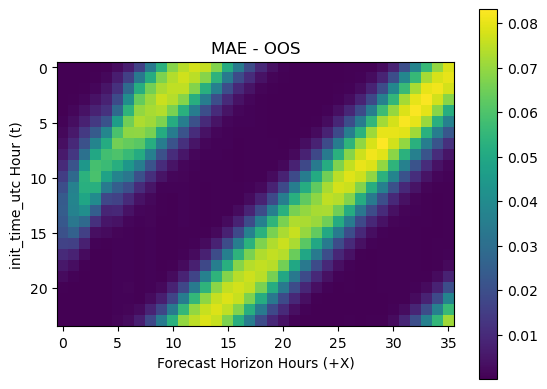

In [179]:
plt.imshow(pd.concat({fh: r.mae_test_loss for fh, r in results.items()}, axis=1))
plt.ylabel("init_time_utc Hour (t)")
plt.xlabel("Forecast Horizon Hours (+X)")
plt.title("MAE - OOS")
plt.colorbar()

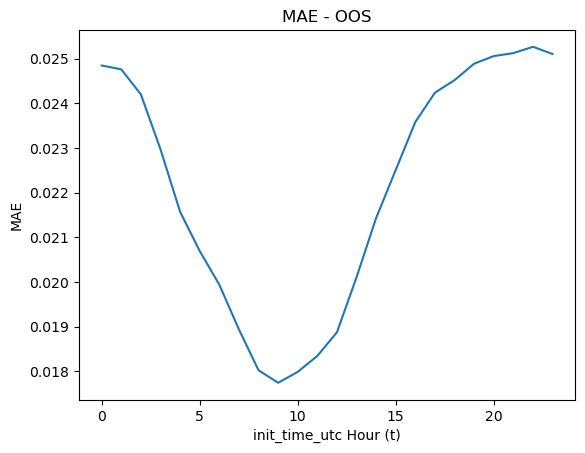

'\nThis makes sense - the primary source of variability in the errors occur at peak day time, therefore further you are from this point, the less your 1 hour lagged PV variable helps your forecast for the midday point\n'

In [199]:
# take forecast horizons in range(0, 24) as to not bias for more than one cycle
pd.concat({fh: r.mae_test_loss for fh, r in results.items()}, axis=1)[range(0, 24)].mean(axis=1).plot()
plt.title("MAE - OOS")
plt.ylabel("MAE")
plt.xlabel("init_time_utc Hour (t)")
plt.show()
"""
This makes sense - the primary source of variability in the errors occur at peak day time, therefore further you are from this point, the less your 1 hour lagged PV variable helps your forecast for the midday point
"""

Text(0.5, 0, 'Forecast Horizon Hours (+X)')

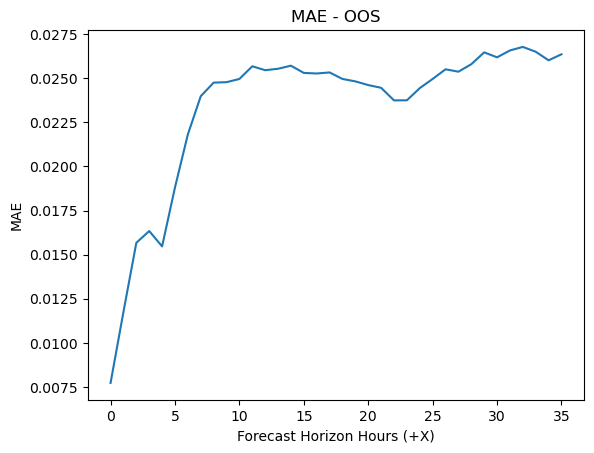

In [182]:
pd.concat({fh: r.mae_test_loss for fh, r in results.items()}, axis=1).mean(axis=0).plot()
plt.title("MAE - OOS")
plt.ylabel("MAE")
plt.xlabel("Forecast Horizon Hours (+X)")